In [ ]:
## Data Analysis Last-Recorded
import numpy as np
import random, os
import pandas as pd
import plotly_express as px # Visualization Tool
import matplotlib.pyplot as plt # Visualization Tool
import seaborn as sns # Visualization Tool

# Seed Fixing
CFG = {
    'NBITS':2048,
    'SEED':42,
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED'])

# Data Loading
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [2]:
import math
# Dependent Designation
X = train.drop(columns = 'pIC50')
y = train['pIC50']

# pIC50 Transform
def ic50_to_pic50(ic50_nM):
    ic50_M = ic50_nM * 1e-9
    pic50 = -math.log10(ic50_M)
    return pic50

X['IC50_nM'] = X['IC50_nM'].apply(ic50_to_pic50)

In [3]:
# SMILES Molecular Formula Vectorization
from rdkit import Chem  
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=CFG['NBITS'])
        fp = generator.GetFingerprint(mol) 
        return np.array(fp)
    else:
        return np.zeros((CFG['NBITS'],))
    
X['morgan'] = X['Smiles'].apply(smiles_to_fingerprint)
test['morgan'] = test['Smiles'].apply(smiles_to_fingerprint)


# Vector transform to Numpy-Array
X_vectors = np.array(X['morgan'].tolist())
test_vectors = np.array(test['morgan'].tolist())

# Numpy-Array transform to float
X_vectors = X_vectors.astype(float)
test_vectors = test_vectors.astype(float)

# Vector separation Addition Individual Columns, and Addition to DataFrame
X_vector_df = pd.DataFrame(X_vectors, columns=[f'vector_{i}' for i in range(X_vectors.shape[1])])
test_vector_df = pd.DataFrame(test_vectors, columns=[f'vector_{i}' for i in range(test_vectors.shape[1])])

# Original DataFrame Merger
X_df = pd.concat([X, X_vector_df], axis=1)
test_df = pd.concat([test, test_vector_df], axis=1)

# test_df = test_df.dropna(axis=0, how='any')


# Vectorization Exception → because, Starting the Pre-processing
vector_columns = [f'vector_{i}' for i in range(1024)]
columns_train_include = [col for col in X_df.columns if col not in vector_columns]
columns_test_include = [col for col in test_df.columns if col not in vector_columns]

X_df = X_df.drop(columns=['Smiles', 'morgan'], errors='ignore')
test_df = test_df.drop(columns=['Smiles', 'morgan'], errors='ignore')

numeric_X = X_df.select_dtypes(include=['number']).columns
object_X = X_df.select_dtypes(include=['object']).columns
object_test = test_df.select_dtypes(include=['object']).columns
numeric_test = test_df.select_dtypes(include=['number']).columns

In [4]:
# Categorical-Data Encoding Start
from sklearn.preprocessing import LabelEncoder

for column in object_X:
    le = LabelEncoder()
    # transform to Train DataFrame
    X_df[column] = le.fit_transform(X_df[column])
    
for column in object_test:
    le = LabelEncoder()
    # transform to Test DataFrame
    test_df[column] = le.fit_transform(test_df[column])

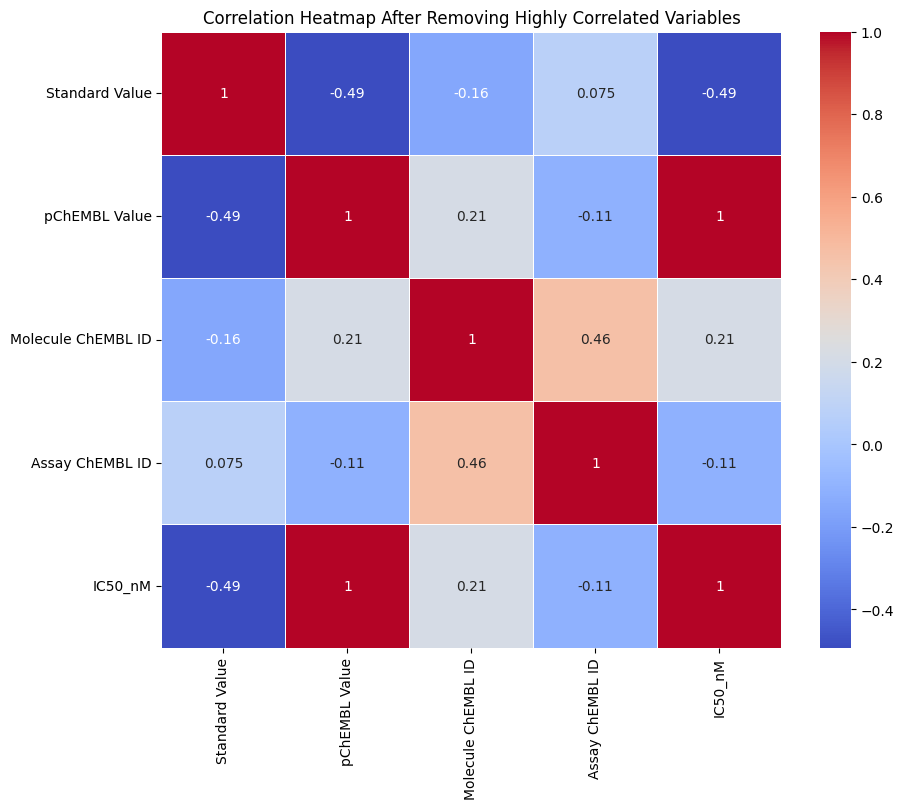

In [5]:
data = X_df[['Standard Value', 'pChEMBL Value', 'Molecule ChEMBL ID', 'Assay ChEMBL ID', 'IC50_nM']]
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap After Removing Highly Correlated Variables')
plt.show()

In [ ]:
"""
I think this data has Intended-Outlier, So, I separate outlier-data and non-outlier-data.
Outlier-data uses MinMaxScaler, and Non-Outlier-Data uses RobustScaler.
"""

from sklearn.preprocessing import RobustScaler, MinMaxScaler
def standard_scale_with_outliers(df, columns):
    # IQR Designation
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    # Non-Outlier-Data Filtering
    non_outliers = df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Scale Data by section
    non_scaler = RobustScaler()
    out_scaler = MinMaxScaler()
    if not non_outliers.empty:
        scaled_non_outliers = non_scaler.fit_transform(non_outliers[columns])
        df.loc[non_outliers.index, columns] = scaled_non_outliers

    # Outlier-Data Filtering
    outliers = df[((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Outlier-Data Scaling
    if not outliers.empty:
        scaled_outliers = out_scaler.fit_transform(outliers[columns])
        df.loc[outliers.index, columns] = scaled_outliers

    return df

for col in ['Standard Value', 'IC50_nM']:
    X_df = standard_scale_with_outliers(X_df, [col])

In [7]:
last_column = [col for col in X_df.columns if col not in vector_columns]

x_train = X_df[last_column]
train_df = pd.concat([x_train, X_df[vector_columns]], axis=1)

In [8]:
'''
train_df = train_df.drop(columns = ['Standard Type', 'Standard Relation', 'Standard Units',
                                     'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type'])
'''

"\ntrain_df = train_df.drop(columns = ['Standard Type', 'Standard Relation', 'Standard Units',\n                                     'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type'])\n"

In [10]:
# PCA Processing → Train Data and test Data are different size. So, I process PCA.
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
train_pca = pca.fit_transform(train_df)
test_pca = pca.fit_transform(test_df)
'''
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Elbow Graph Visualization
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()
'''

# PCA Result transform to DataFrame
train_pca_df = pd.DataFrame(train_pca)
test_pca_df = pd.DataFrame(test_pca)

In [13]:
# NRMSE Calculating Function
from sklearn.metrics import mean_squared_error

def nrmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse / (np.max(y_true) - np.min(y_true))

In [14]:
# pIC50 transform to IC50_nM
def pIC50_to_IC50(pic50):
    ic50_nM = 10 ** (9 - pic50)
    return ic50_nM

In [15]:
# AutoML Using
from pycaret.regression import *

# AutoML Starting
data = pd.concat([train_pca_df, y], axis=1) # Setup PyCaret 

reg = setup(data=data, target='pIC50', session_id=123, normalize=False)

add_metric('nrmse', 'Normalized RMSE', score_func=nrmse, greater_is_better=False)

# Model Comparision For Using NRMSE
best_model = compare_models(sort='nrmse')

# Selecting Model Prediction
final_model = finalize_model(best_model)

# Hyper-Parameter Tuning
tuned_model = tune_model(final_model, optimize='nrmse', n_iter=50)

# Tuned-Model Uses Prediction of Data. 
predictions = predict_model(tuned_model, data=test_pca_df)

,Description,Value
0,Session id,123
1,Target,pIC50
2,Target type,Regression
3,Original data shape,"(1952, 6)"
4,Transformed data shape,"(1952, 6)"
5,Transformed train set shape,"(1366, 6)"
6,Transformed test set shape,"(586, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Normalized RMSE,TT (Sec)
lr,Linear Regression,0.6236,0.7223,0.8492,0.4092,0.1081,0.0916,0.0000,0.4130
gbr,Gradient Boosting Regressor,0.4416,0.3938,0.6267,0.6771,0.0809,0.0645,0.0000,0.0400
ada,AdaBoost Regressor,0.6137,0.5591,0.7473,0.5410,0.0950,0.0870,0.0000,0.0210
et,Extra Trees Regressor,0.3380,0.2874,0.5338,0.7646,0.0692,0.0491,0.0000,0.0410
rf,Random Forest Regressor,0.3536,0.3091,0.5550,0.7469,0.0716,0.0512,0.0000,0.0750
dt,Decision Tree Regressor,0.4477,0.5710,0.7529,0.5355,0.0963,0.0639,0.0000,0.0080
knn,K Neighbors Regressor,0.6689,0.7944,0.8895,0.3490,0.1110,0.0967,0.0000,0.0110
lightgbm,Light Gradient Boosting Machine,0.3798,0.3257,0.5694,0.7331,0.0738,0.0553,0.0000,0.1480
par,Passive Aggressive Regressor,2.0637,7.7401,2.6979,-5.2462,0.4348,0.2822,0.0000,0.0100
omp,Orthogonal Matching Pursuit,0.9154,1.1746,1.0830,0.0405,0.1338,0.1308,0.0000,0.0070


,MAE,MSE,RMSE,R2,RMSLE,MAPE,Normalized RMSE
Fold,,,,,,,
0,0.6294,0.7264,0.8523,0.3978,0.1091,0.0932,-0.0000
1,0.6202,0.6611,0.8131,0.4133,0.1030,0.0902,-0.0000
2,0.6462,0.7685,0.8767,0.4139,0.1110,0.0949,-0.0000
3,0.6701,0.7839,0.8854,0.3865,0.1097,0.0956,-0.0000
4,0.6053,0.6395,0.7997,0.4577,0.0999,0.0860,-0.0000
5,0.5927,0.6578,0.8111,0.4884,0.1045,0.0891,-0.0000
6,0.5900,0.6979,0.8354,0.4005,0.1092,0.0889,-0.0000
7,0.6467,0.7892,0.8884,0.3226,0.1130,0.0939,-0.0000
8,0.5813,0.6907,0.8311,0.3788,0.1056,0.0858,-0.0000


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [16]:
# Outputting The Result
result = predict_model(tuned_model, data=pd.DataFrame(test_pca))

# Submission File Making

sample["pIC50"] = result['prediction_label']
sample["IC50_nM"] = pIC50_to_IC50(sample["pIC50"])
sample = sample.drop(columns = 'pIC50')

# File Exporting.
sample.to_csv("./final.csv", index=False)

In [17]:
sample

,ID,IC50_nM
0,TEST_000,28.257717
1,TEST_001,10.752097
2,TEST_002,14.061271
3,TEST_003,218.440201
4,TEST_004,140.590012
...,...,...
108,TEST_108,20.223207
109,TEST_109,46.803215
110,TEST_110,19.362123
111,TEST_111,22.767660
